<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/cat_skeleton_detection_three_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: albumentations, bokeh, dask, distributed, fastai, PyDrive


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("cat_keypoints_train", {}, "/content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json", "/content/drive/MyDrive/Dataset/cats/images")

In [ ]:
#MetadataCatalog.remove("person_keypoints_train")
#DatasetCatalog.remove("person_keypoints_train")

In [18]:
keypoint_names = ['nose', 'left_eye', 'right_eye']
keypoint_flip_map = [('left_eye', 'right_eye'),('nose', 'left_eye'),('nose', 'right_eye')]
keypoint_connection_rules = [('left_eye', 'left_eye', (102, 204, 255))]
MetadataCatalog.remove("cat_keypoints_train")

In [19]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("cat_keypoints_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("cat_keypoints_train").thing_classes = ["threepoints"]
MetadataCatalog.get("cat_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_keypoints_train").evaluator_type="coco"

In [20]:
cat_metadata = MetadataCatalog.get("cat_keypoints_train")
cat_metadata

Metadata(evaluator_type='coco', keypoint_connection_rules=[('left_eye', 'left_eye', (102, 204, 255))], keypoint_flip_map=[('left_eye', 'right_eye'), ('nose', 'left_eye'), ('nose', 'right_eye')], keypoint_names=['nose', 'left_eye', 'right_eye'], name='cat_keypoints_train', thing_classes=['threepoints'], thing_dataset_id_to_contiguous_id={1: 0})

In [21]:
dataset_dicts = DatasetCatalog.get("cat_keypoints_train")
dataset_dicts[0]

[02/25 07:26:11 d2.data.datasets.coco]: Loaded 120 images in COCO format from /content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json


{'file_name': '/content/drive/MyDrive/Dataset/cats/images/00000001_000.jpg',
 'height': 500,
 'width': 375,
 'image_id': 1,
 'annotations': [{'iscrowd': 0,
   'bbox': [177.27, 162.65, 63.58, 30.47],
   'keypoints': [200.16, 193.62, 2, 177.77, 163.15, 2, 241.35, 166.15, 2],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

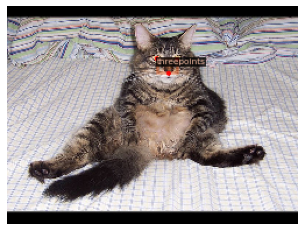

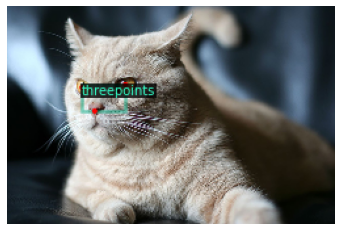

In [22]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

cat_metadata = MetadataCatalog.get("cat_keypoints_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)    
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [38]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cat_keypoints_train",)


#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_train.pth")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((3, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/25 07:49:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.keypoint_head.conv_fcn1.{bias, weight}
roi_heads.keypoint_head.conv_fcn2.{bias, weight}
roi_heads.keypoint_head.conv_fcn3.{bias, weight}
roi_heads.keypoint_head.conv_fcn4.{bias, weight}
roi_heads.keypoint_head.conv_fcn5.{bias, weight}
roi_heads.keypoint_head.conv_fcn6.{bias, weight}
roi_heads.keypoint_head.conv_fcn7.{bias, weight}
roi_heads.keypoint_head.c

[02/25 07:49:30 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/25 07:49:40 d2.utils.events]:  eta: 0:01:31  iter: 19  total_loss: 8.956  loss_cls: 0.5491  loss_box_reg: 0.004402  loss_keypoint: 7.762  loss_rpn_cls: 0.6756  loss_rpn_loc: 0.006949  time: 0.4976  last_time: 0.4785  data_time: 0.0262  last_data_time: 0.0075   lr: 2.3976e-05  max_mem: 3916M
[02/25 07:49:50 d2.utils.events]:  eta: 0:01:20  iter: 39  total_loss: 8.192  loss_cls: 0.06004  loss_box_reg: 0.0109  loss_keypoint: 7.438  loss_rpn_cls: 0.6409  loss_rpn_loc: 0.009701  time: 0.5085  last_time: 0.5206  data_time: 0.0209  last_data_time: 0.0744   lr: 4.8951e-05  max_mem: 3916M
[02/25 07:50:00 d2.utils.events]:  eta: 0:01:11  iter: 59  total_loss: 6.884  loss_cls: 0.04685  loss_box_reg: 0.006515  loss_keypoint: 6.28  loss_rpn_cls: 0.5791  loss_rpn_loc: 0.01097  time: 0.5067  last_time: 0.5299  data_time: 0.0123  last_data_time: 0.0080   lr: 7.3926e-05  max_mem: 3916M
[02/25 07:50:11 d2.utils.events]:  eta: 0:01:01  iter: 79  total_loss: 6.029  loss_cls: 0.04546  loss_box_reg: 0.0

In [34]:
del cfg

In [42]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3

predictor = DefaultPredictor(cfg)

[02/25 07:53:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [43]:
im = cv2.imread("/content/drive/MyDrive/Dataset/cats/images/00000001_000.jpg")
outputs = predictor(im)
print(outputs["instances"])

Instances(num_instances=5, image_height=500, image_width=375, fields=[pred_boxes: Boxes(tensor([[1.5751e-01, 1.4551e+02, 2.8561e+02, 3.0856e+02],
        [8.2198e+01, 1.2115e+02, 3.3395e+02, 3.3812e+02],
        [1.0010e+02, 2.1275e+02, 3.2046e+02, 4.2007e+02],
        [1.8106e+02, 1.1463e+02, 3.4904e+02, 4.3818e+02],
        [1.1836e+02, 9.4810e+01, 3.7366e+02, 2.7028e+02]], device='cuda:0')), scores: tensor([0.1245, 0.1181, 0.1179, 0.1034, 0.1034], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0], device='cuda:0'), pred_keypoints: tensor([[[2.5234e+01, 1.6542e+02, 1.2417e-03],
         [8.6060e-01, 1.4621e+02, 3.0954e-03],
         [2.6053e+02, 1.4621e+02, 9.4232e-04]],

        [[8.2900e+01, 2.4109e+02, 9.4594e-04],
         [8.2900e+01, 1.2185e+02, 2.1021e-03],
         [3.1173e+02, 1.2185e+02, 1.0881e-03]],

        [[1.0080e+02, 2.3872e+02, 1.1481e-03],
         [1.0080e+02, 2.1345e+02, 2.3404e-03],
         [3.0104e+02, 2.1345e+02, 1.1401e-03]],

        [[1.8176e+02, 3.40

In [44]:
list(outputs['instances'].pred_classes)

[tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0')]

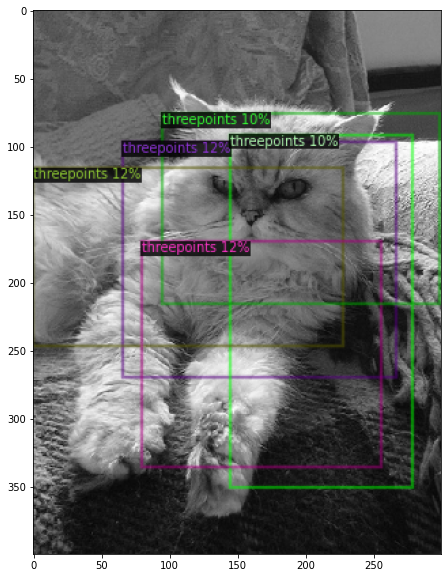

In [45]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1],
  metadata=cat_metadata, 
  scale=0.8, 
  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)


v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()


# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj